
# Learning Pandas using enigma.io's API and datasets.

***

## Data exploration of NYC property assessment values (2010, 2014).

***Note***: Ideally I'd use multiple datasets from different sources that overlap a little, but that also augment each other. 

That's what makes enigma particularly interesting, the simultaneous "normalized" access to datasets of different origins.  

But for now, baby Pandas steps, and start with the NYC property assessments dataset, which may allow us to do fun things such as being nosy and see how much the houses in our block have gained in value recently, and how many properties the Scottos own.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np



## Download the two datasets making use of enigma.io API.

Go to last cell in this notebook, which shows an initial version of a Python client to enigma.io.
To download a dataset, the module containing the client would be invoked like this...

      ENV_ENIGMA_APIKEY=xyz ./enigma_client.py us.states.ny.cities.nyc.property.assessment-valuation.avroll.2010
      ENV_ENIGMA_APIKEY=xyz ./enigma_client.py us.states.ny.cities.nyc.property.assessment-valuation.avroll.2014

## Taking too long to read the csv file into a Pandas DataFrame.

### What did we just download? Check-out file sizes, number of rows...


In [2]:
import os

num_lines_10 = !wc -l nyc_property_assessments/nyc.prop_assess_2010.csv
num_lines_14 = !wc -l nyc_property_assessments/nyc.prop_assess_2014.csv
print("Num lines 2010: {:,}".format(int(num_lines_10[0].split()[0])))
print("Num lines 2014: {:,}".format(int(num_lines_14[0].split()[0])))

print()

nyc_props_2010_fname = "nyc_property_assessments/nyc.prop_assess_2010.csv"
nyc_props_2014_fname = "nyc_property_assessments/nyc.prop_assess_2014.csv"
print("File size 2010: {:,}".format(os.stat(nyc_props_2014_fname).st_size))
print("File size 2014: {:,}".format(os.stat(nyc_props_2010_fname).st_size))


Num lines 2010: 1,060,513
Num lines 2014: 1,088,351

File size 2010: 164,461,696
File size 2014: 185,122,823


## So, around file sizes of 160MB for 2010 and 185MB for 2014.

#### Hmmm, importing these as Pandas DataFrames may thrash my humble laptop/VM.

#### Run some tests to get an idea about memory usage.<br>Do multiple read_csv(), increasing the number of rows read in each one.

See if memory consumption increases linearly.<br>Project mem usage for max number of rows.


In [3]:
# Choose chunks of lines from different sections of the csv file
# so that they are not always from the beginning of the file.
# (just in case row sizes progressively increase/decrease/change)

# reminder: 2010 file: 700k lines
from collections import OrderedDict

dfs_info = OrderedDict()
dfs_info[100]  = dict(numrows=100,  rowstart=1024*1)
dfs_info[1000] = dict(numrows=1000, rowstart=1024*10)
dfs_info[10000] = dict(numrows=10000, rowstart=1024*100)
dfs_info[100000] = dict(numrows=100000, rowstart=1024*500)

for df_info in dfs_info.values():
    numrows, rowstart = df_info["numrows"], df_info["rowstart"]
    df_info["df"] = pd.read_csv(nyc_props_2010_fname, header=0,
                                skiprows=range(1,rowstart+1), nrows=numrows)
    print("\n\n====> Data frame info (for {:,} rows)\n"
          "====> (check 'memory usage' line)".format(numrows))
    df_info["df"].info()


# won't need previous test DataFrames - indicate that we can free that memory...
del dfs_info




====> Data frame info (for 100 rows)
====> (check 'memory usage' line)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 32 columns):
bble        100 non-null int64
borough     100 non-null object
block       100 non-null int64
lot         100 non-null int64
easement    0 non-null float64
owner       36 non-null object
bldgcl      100 non-null object
taxclass    100 non-null object
ltfront     100 non-null int64
ltdepth     100 non-null int64
ext         0 non-null float64
stories     100 non-null int64
fullval     100 non-null float64
avland      100 non-null float64
avtot       100 non-null float64
exland      100 non-null float64
extot       100 non-null float64
excd1       98 non-null float64
staddr      100 non-null object
zip         99 non-null float64
exmptcl     0 non-null float64
bldfront    100 non-null int64
blddepth    100 non-null int64
avland2     99 non-null float64
avtot2      99 non-null float64
exland2     98 non-null float6

/home/jds/.pyvenvs/liveresume/lib/python3.4/site-packages/pandas/io/parsers.py:1164: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


***

## So, it does increase linearly (25kB/100 rows, 250kB/1kr ... 25MB/100krows).<br>For 1M rows, that'll be around 250MB RAM (per dataset). 

Playing with both full datasets/DataFrames simultaneously (2010 and 2014) will be a bit slow in my laptop.<br>Explore one dataset at a time to start with...

***
## Let's start by using a subset of the 2010 csv file to explore the schema.<br>Select all rows where the zip code is 11231 (Carroll Gardens, Brooklyn).

#####Use the linux csvgrep util to select zip cols that match 11231.

In [4]:
props_2010_11231_fname = "nyc_property_assessments/2010_zip11231.csv"

if not os.path.exists(props_2010_11231_fname):
    print("Creating 11231 csv file...")
    !csvgrep -c zip -r "11231" nyc_property_assessments/nyc.prop_assess_2010.csv > nyc_property_assessments/props_2010_zip11231.csv


##Start exploring the data/schema.

In [5]:
df10_11231 = pd.read_csv(props_2010_11231_fname)

### Confirm we filtered correctly. Also, how many rows/properties in 11231? 

In [6]:
print("df.shape: ", df10_11231.shape)
print("Confirm we filtered correctly. Num rows where zip==11231: ", 
      len(df10_11231.zip == 11231))


df.shape:  (6260, 32)
Confirm we filtered correctly. Num rows where zip==11231:  6260


###OK, generating a subset csv file is useful. Let's make it a more generic util func.

Pass in a colname ("zip") and a pattern we want to match (11231),
and create a new subset csv file, matching the search criteria.

In [7]:
import os
def create_subset_csv(colname, regex_str, orig_csv_fname, new_csv_fname=None):
    assert os.path.exists(orig_csv_fname)
    
    if not new_csv_fname:
        orig_split = os.path.split(orig_csv_fname)
        new_csv_fname = "{col}_{reg}__{orig}".format(
            col=colname, reg=regex_str, orig=orig_split[-1])
        new_full_name = os.path.join(orig_split[0], new_csv_fname)

    if not os.path.exists(new_full_name):
        os.system('csvgrep -c {col} -r "{reg}" {orig} > {new}'.format(
            col=colname, reg=regex_str, orig=orig_csv_fname, new=new_full_name))
    return new_full_name


In [8]:
# let's use it to re-generate the 11231 zip subset 
# and confirm via df.info() that the result is equivalent...
new_fname = create_subset_csv("zip", "11231", 
                              "nyc_property_assessments/nyc.prop_assess_2010.csv")

df10_zip11231 = pd.read_csv(new_fname)
df10_zip11231.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6260 entries, 0 to 6259
Data columns (total 32 columns):
bble        6260 non-null float64
borough     6260 non-null object
block       6260 non-null int64
lot         6260 non-null int64
easement    5 non-null object
owner       6087 non-null object
bldgcl      6260 non-null object
taxclass    6260 non-null object
ltfront     6260 non-null int64
ltdepth     6260 non-null int64
ext         474 non-null object
stories     5744 non-null float64
fullval     6260 non-null float64
avland      6260 non-null float64
avtot       6260 non-null float64
exland      6260 non-null float64
extot       6260 non-null float64
excd1       2823 non-null float64
staddr      6260 non-null object
zip         6260 non-null int64
exmptcl     180 non-null object
bldfront    6260 non-null int64
blddepth    6260 non-null int64
avland2     1991 non-null float64
avtot2      1991 non-null float64
exland2     533 non-null float64
extot2      786 non-null float64
excd

## Cool, that worked. Some cleanup from previous work above...

In [9]:
# some cleanup; delete previous dataframes that we won't use anymore
# frees mem and prevents inadvertent references to them in subsequent cells (guilty!)
del props_2010_11231_fname
del df10_11231

## Ok, some data exploration...

### What are the columns?

In [10]:
df10_zip11231.columns

Index(['bble', 'borough', 'block', 'lot', 'easement', 'owner', 'bldgcl', 'taxclass', 'ltfront', 'ltdepth', 'ext', 'stories', 'fullval', 'avland', 'avtot', 'exland', 'extot', 'excd1', 'staddr', 'zip', 'exmptcl', 'bldfront', 'blddepth', 'avland2', 'avtot2', 'exland2', 'extot2', 'excd2', 'period', 'year', 'valtype', 'serialid'], dtype='object')

### Make the column info more visually friendly.

In [11]:
# Column names not that visually clear; make them easier to read...
def prettify_colnames(df, cols_per_row=7):
    cols = sorted(df.columns)
    colsize = 2 + max(len(colname) for colname in cols)
    outstr = ""
    for ix, colname in enumerate(cols):
        outstr += "{nl}{cn:{sz}}".format(
            nl = "" if (ix+1) % cols_per_row else "\n", cn=colname, sz=colsize)
    return outstr

# try again...
print("\nColumn names...\n\n{}".format(prettify_colnames(df10_zip11231, 6)))


Column names...

avland    avland2   avtot     avtot2    bble      
blddepth  bldfront  bldgcl    block     borough   easement  
excd1     excd2     exland    exland2   exmptcl   ext       
extot     extot2    fullval   lot       ltdepth   ltfront   
owner     period    serialid  staddr    stories   taxclass  
valtype   year      zip       


## What do these column headers mean!? Kind of cryptic names...

### Navigate enigma.io website. <br>You can click on "Description" for any table/dataset.<br>A modal window pops up.<br> You can choose to "export" the column descriptions as a file.


Downloaded it, unzipped it. It contains 2 files...

     table-info.csv
     column-info.csv
     

### Read the column-info.csv file.

In [12]:
colinfo_df = pd.read_csv("nyc_property_assessments/2010-column-info.csv")
colinfo_df.head()

,Column Name,Column Description,Column API ID,Column Type
0,Year,Year,year,type_varchar
1,BBLE,"Concatenation of Borough, Block, Lot, & Easement",bble,type_varchar
2,Owner,Owner,owner,type_varchar
3,Street Address,Street Address,staddr,type_varchar
4,Block,Valid Block Ranges By Borough: Manhattan - [1 ...,block,type_varchar


In [13]:
# peek
colinfo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 4 columns):
Column Name           32 non-null object
Column Description    32 non-null object
Column API ID         32 non-null object
Column Type           32 non-null object
dtypes: object(4)
memory usage: 1.2+ KB


In [14]:
print("number of cols in dataset: ", len(df10_zip11231.columns))
print("number of columns described in the column-info file: ", colinfo_df.shape[0])

number of cols in dataset:  32
number of columns described in the column-info file:  32


### Cool, every column in the dataset is described!

In [15]:
# display description for all cols
pd.set_option("max_rows", 50)
colinfo_df.ix[:, ["Column API ID", "Column Description", "Column Type"]].sort("Column API ID")


,Column API ID,Column Description,Column Type
8,avland,Actual Land Value,type_numeric
26,avland2,Transitional Land Value,type_numeric
9,avtot,Actual Total Value,type_numeric
27,avtot2,Transitional Total Value,type_numeric
1,bble,"Concatenation of Borough, Block, Lot, & Easement",type_varchar
25,blddepth,Building Depth in Feet,type_numeric
24,bldfront,Building Frontage in Feet,type_numeric
14,bldgcl,Building Class - See form listing a descriptio...,type_varchar
4,block,Valid Block Ranges By Borough: Manhattan - [1 ...,type_varchar
13,borough,[1] - Manhattan [2] - Bronx [3] - Brooklyn [4]...,type_varchar


In [16]:
# Reminder of what the real data looks like, also w/ cols sorted alphab.
pd.set_option('max_columns', 50)
df10_zip11231.head().ix[:, sorted(df10_zip11231.columns)]


,avland,avland2,avtot,avtot2,bble,blddepth,bldfront,bldgcl,block,borough,easement,excd1,excd2,exland,exland2,exmptcl,ext,extot,extot2,fullval,lot,ltdepth,ltfront,owner,period,serialid,staddr,stories,taxclass,valtype,year,zip
0,0,NaN,0,NaN,3004097502,0,0,R0,409,BROOKLYN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,0,7502,100,20,NaN,FINAL,246026,91 DOUGLASS STREET,NaN,2,AC-TR,2009/10,11231
1,267,267,3498,2563,3004211044,0,0,R5,421,BROOKLYN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,7774,1044,0,0,NaN,FINAL,246896,344 DE GRAW STREET,NaN,4,AC-TR,2009/10,11231
2,0,NaN,0,NaN,3004217501,44,107,R0,421,BROOKLYN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,0,7501,100,125,NaN,FINAL,247042,344 DE GRAW STREET,6,2,AC-TR,2009/10,11231
3,0,NaN,0,NaN,3003190009,0,0,D7,319,BROOKLYN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,0,9,97,19,POSTGRADUATE CNTR MEN,FINAL,256645,169 COLUMBIA STREET,NaN,2,AC-TR,2009/10,11231
4,0,NaN,0,NaN,3003367502,0,0,R0,336,BROOKLYN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,0,7502,100,61,NaN,FINAL,256719,156 SACKETT STREET,6,2,AC-TR,2009/10,11231


### Select what seems like a useful subset of the 32 columns.<br> We'll use this col subset for our data exploration.

In [17]:
# these columns seem interesting 
# (owner, street name & number, value, lot front/depth in ft., num of stories, ...)
colnames_10 = ['owner',
               'fullval',
               'zip',
               'staddr',
               'ltfront',
               'ltdepth',
               'stories',
               'easement']

# index the descr table by the API name...
cidx10 = colinfo_df.set_index("Column API ID")

# map the cryptic dataset colnames to a more user-friendly name
# (preserve the col order listed above)
cols_subset = OrderedDict()
for cn in colnames_10:
    cols_subset[cn] = cidx10.ix[cn]["Column Name"].strip()

# rename cols of interest
#tmp_renamed = df10_zip11231.rename(columns = cols_subset)
df10_zip11231_subcols = df10_zip11231.rename(columns = cols_subset)

# and drop all other cols
all_cols = set(df10_zip11231.columns)
df10_zip11231_subcols = df10_zip11231_subcols.drop(all_cols - set(cols_subset.keys()), axis=1)
df10_zip11231_subcols = df10_zip11231_subcols.reindex_axis(cols_subset.values(), axis=1)

In [18]:
df10_zip11231_subcols.columns

Index(['Owner', 'Full Value', 'Zip', 'Street Address', 'Lot Frontage', 'Lot Depth', 'Stories', 'Easement'], dtype='object')

In [19]:
# let's try these new column names, should make table easier to decode.
df10_zip11231_subcols.ix[100:105]

,Owner,Full Value,Zip,Street Address,Lot Frontage,Lot Depth,Stories,Easement
100,SOUTH BKLYN RENEWALAS,630000,11231,149 COLUMBIA STREET,26,76,4,NaN
101,ZAHA AHMAD,841000,11231,147A COLUMBIA STREET,18,97,4,NaN
102,ZAHA T AHMAD,548000,11231,147 COLUMBIA STREET,18,97,4,NaN
103,JACK L. IRWIN,665000,11231,145 COLUMBIA STREET,19,97,4,NaN
104,SOUTH BKLYN RENEWALAS,581000,11231,143 COLUMBIA STREET,19,97,4,NaN
105,"CASANOVA, SAHYLI",1193000,11231,139 COLUMBIA STREET,18,97,3,NaN


## OK, enough column cleanup for now. Explore the table's contents.

## Delete the subset dataframe that we used to investigate the columns.<br>And go for it, read the full 2010 dataset.

In [20]:
del df10_zip11231
del df10_zip11231_subcols

# col 0 ("bble") is generating warnings during the read (mixed dtypes). Be specific.
df2010 = pd.read_csv(nyc_props_2010_fname, dtype={'bble': object})

### And do the column reduction + renaming.

In [21]:
# rename cols of interest; drop all others; reindex
all_cols = set(df2010.columns)
df2010_subcols = df2010.rename(columns = cols_subset)
df2010_subcols = df2010_subcols.drop(all_cols - set(cols_subset.keys()), axis=1)
df2010_subcols = df2010_subcols.reindex_axis(cols_subset.values(), axis=1)

del df2010

###From the 2010 df.info() below<br><br>Around 1M rows <br><br>We had projected ~ 250MB RAM for the full table (32 cols).<br>Note that having cut the num of cols to 7, proportionally reduced the mem size - great!<br><br>Most columns are mostly populated.<br>Others are not, but make sense (4600 easements).<br>Assessment value ($) is a float which is good for stats calculations (also, ints for feet values).<br><br>So, overall, looks pretty clean. Good start.

In [22]:
print("===> df2010_subcols shape:", df2010_subcols.shape, "\n\n")

df2010_subcols.info()

===> df2010_subcols shape: (1060512, 8) 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1060512 entries, 0 to 1060511
Data columns (total 8 columns):
Owner             1029890 non-null object
Full Value        1060512 non-null float64
Zip               1030018 non-null float64
Street Address    1059833 non-null object
Lot Frontage      1060512 non-null int64
Lot Depth         1060512 non-null int64
Stories           1003082 non-null float64
Easement          4615 non-null object
dtypes: float64(3), int64(2), object(3)
memory usage: 72.8+ MB


### Quick overview of the cols' aggregates.

In [23]:
# 2010
df2010_subcols.describe()


,Full Value,Zip,Lot Frontage,Lot Depth,Stories
count,1.060512e+06,1030018.000000,1060512.000000,1060512.000000,1003082.000000
mean,8.809222e+05,10924.934832,36.774087,89.517267,4.937013
std,1.151490e+07,527.595805,73.531873,76.386993,8.310756
min,0.000000e+00,10001.000000,0.000000,0.000000,1.000000
25%,3.230000e+05,10314.000000,19.000000,82.000000,2.000000
50%,4.680000e+05,11214.000000,25.000000,100.000000,2.000000
75%,6.350000e+05,11364.000000,40.000000,100.000000,3.000000
max,6.045000e+09,33803.000000,9999.000000,9999.000000,119.000000


# ====  Everything below is work-in-progress / incomplete ====
# ====  Everything below is work-in-progress / incomplete ====
# ====  Everything below is work-in-progress / incomplete ====


## Let's group by street. Which streets have the highest property values?

In [22]:
pd.set_option("display.max_rows", 50)

grp09_str = df10_zip11231_subcols.groupby("Street")


print("===> 2010, zip 11231: top 10 street cnt:\n\n", 
      grp09_str.size().order(ascending=False)[:10])

max09_str = grp09_str["Current Total Market Value"].max().order(ascending=False)
mean09_str = grp09_str["Current Total Market Value"].mean().order(ascending=False)


print("\n\n===> 2010, zip 11231: top max value, per street:\n\n", max09_str[:10])
print("\n\n===> 2010, zip 11231: top mean value, per street:\n\n", mean09_str[:10])



===> 2010, zip 11231: top 10 street cnt:

 Street
PRESIDENT STREET    202
UNION STREET        190
SACKETT STREET      174
CARROLL STREET      158
CLINTON STREET      140
DE GRAW STREET      123
COLUMBIA STREET     120
2 STREET            120
COURT STREET        101
VAN BRUNT STREET     85
dtype: int64


===> 2010, zip 11231: top max value, per street:

 Street
PRESIDENT STREET    3534000
CLINTON STREET      3511000
TOMPKINS PLACE      3445000
KANE STREET         3177000
2 PLACE             3027000
1 PLACE             2967000
SACKETT STREET      2886000
3 PLACE             2829000
DE GRAW STREET      2794000
HENRY STREET        2730000
Name: Current Total Market Value, dtype: float64


===> 2010, zip 11231: top mean value, per street:

 Street
TOMPKINS PLACE    2268656.190476
2 PLACE           1935108.935484
KANE STREET       1820101.538462
STRONG PLACE      1794903.703704
1 PLACE           1679558.823529
CLINTON STREET    1668341.371429
3 PLACE           1610765.476190
4 PLACE         

(array([  0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 7 Text xticklabel objects>)

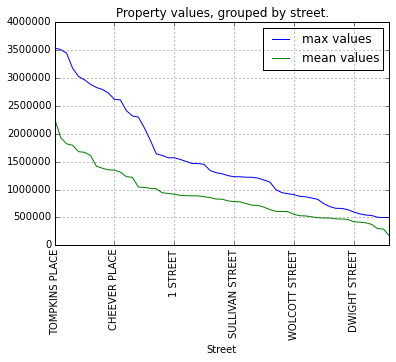

In [23]:
import matplotlib.pyplot as plt

max09_str.plot(label="max values")
mean09_str.plot(label="mean values")

plt.legend(loc="best")
plt.title("Property values, grouped by street.")
plt.xticks(rotation=90)


## Let's choose the street with the highest standard deviation<br>Haves and nots.

In [24]:
grp09_str["Current Total Market Value"].std().order(ascending=False)[:10]


Street
KANE STREET         678945.611802
TOMPKINS PLACE      677017.691262
RAPELYE STREET      619836.806479
CLINTON STREET      619010.685420
BUTLER STREET       597896.937914
CARROLL STREET      578602.890832
PRESIDENT STREET    578519.788763
DE GRAW STREET      534861.894670
UNION STREET        524319.869057
2 PLACE             495189.824648
Name: Current Total Market Value, dtype: float64

### The block party at the 200's is where you wanna be.

In [194]:
df10_zip11231_subcols.columns

kane_std = df10_zip11231_subcols[df10_zip11231_subcols.Street == "KANE STREET"][
        ["Current Total Market Value", "Owner", "Lowest House Number", "Units", "Lot Frontage", "Lot Depth" ]].\
        sort_index(by="Current Total Market Value", ascending=False)
pd.set_option("display.max_rows", 10)
kane_std

,Current Total Market Value,Owner,Lowest House Number
24,3177000,JAMES BODE,000000000235
23,2911000,CARA GAVIN,000000000239
31,2824000,DONALD P SCHENK,000000000219
28,2809000,THOMAS O BOUCHER,000000000225
29,2809000,"MELAMED, MARK A",000000000223
...,...,...,...
49,1022000,"KANAS, JENNIFER",000000000090
15,994000,"BILGER, KARINA",000000000129
3,837000,SUTTON ALBERT,000000000111
100,781000,"MILDE, CLAIBORNE",000000000140


In [25]:
cols_subset.values()

ValuesView(OrderedDict([('owner', 'Owner'), ('fullval', 'Full Value'), ('staddr', 'Street Address'), ('ltfront', 'Lot Frontage'), ('ltdepth', 'Lot Depth'), ('stories', 'Stories'), ('easement', 'Easement')]))

In [30]:
df10_zip11231_subcols.columns


kane_std = df10_zip11231_subcols[df10_zip11231_subcols.Street == "KANE STREET"][
        ["Current Total Market Value", "Owner", "Lowest House Number", "Units", "Lot Frontage (Ft.)", "Lot Depth (Ft.)" ]].\
        sort_index(by="Current Total Market Value", ascending=False)
pd.set_option("display.max_rows", 10)
kane_std

,Current Total Market Value,Owner,Lowest House Number,Units,Lot Frontage (Ft.),Lot Depth (Ft.)
24,3177000,JAMES BODE,000000000235,1,24.00,99.00
23,2911000,CARA GAVIN,000000000239,3,26.00,99.83
31,2824000,DONALD P SCHENK,000000000219,3,22.00,100.00
28,2809000,THOMAS O BOUCHER,000000000225,2,25.00,100.00
29,2809000,"MELAMED, MARK A",000000000223,3,25.00,100.00
...,...,...,...,...,...,...
49,1022000,"KANAS, JENNIFER",000000000090,3,22.00,80.50
15,994000,"BILGER, KARINA",000000000129,2,21.00,44.00
3,837000,SUTTON ALBERT,000000000111,0,21.33,94.83
100,781000,"MILDE, CLAIBORNE",000000000140,1,30.00,30.00


# python client for enigma.io API - for now it just provides "export" support

In [31]:
#!/usr/bin/env python

import os
import sys
import time
import argparse
import requests
from requests import RequestException

ARGPARSER = argparse.ArgumentParser()
ARGPARSER.add_argument("datapath")
ARGPARSER.add_argument("-o", "--outfname", dest="outfname", required=False)


class EnigmaClient:
    ENIG_RETCODE_SUCCESS = 0
    ENIG_RETCODE_TIMEOUT = 1
    ENIG_RETCODE_ERROR   = 2

    _QUERY_TEMPLATE = "https://api.enigma.io/v2/{op}/{key}/{datapath}/{params}"
    _EXPORTAPI_MAX_SECS_TIMEOUT = 120
    _EXPORTAPI_POLL_SECS_INTERVAL = 1
    _EXPORTAPI_CHUNK_SIZE = 1024 * 64

    def __init__(self, apikey):
        self.apikey = apikey


    # Tables are exported as Gzipped CSV files. 
    # 
    # Exports of large tables may take some time, so exports are processed
    # asynchronously.
    # 
    # When the export API is called, an export is queued and the API immediately
    # returns a URL pointing to the future location of the exported file. Users
    # should poll the URL until the file becomes available.
    # 
    # Note: this is a synchronous call. Caller waits (up to max_secs_timeout)
    #       until data is made available by Enigma backend, and then downloaded.
    #       Caller should check err_code if the export fails.
    # 
    # Returns one of: ENIG_RETCODE_SUCCESS, ENIG_RETCODE_TIMEOUT, ENIG_RETCODE_ERROR
    # 
    def export(self, datapath, parameters=None,
               max_secs_timeout=None, outfname=None):

        query_str = self._QUERY_TEMPLATE.format(op="export", key=self.apikey,
                                                datapath=datapath, params="")
        # make a query, which sends back the URL that we'll have to poll
        # until it eventually responds back with the gzipped csv file.
        resp = requests.get(query_str)
        resp_json = resp.json()
        export_url = resp_json["export_url"]

        if not outfname:
            # derive it from the URL
            outfname = export_url[export_url.strip("/").rfind("/")+1:]
            if "?" in outfname:
                outfname = outfname[:outfname.rfind("?")]

        return self._download_file(export_url, outfname)
        
    def _download_file(self, export_url, outfname):
        timeout_secs_remaining = self._EXPORTAPI_MAX_SECS_TIMEOUT
        poll_time_interval = self._EXPORTAPI_POLL_SECS_INTERVAL

        completed = False
        print("About to attempt exporting export URL: {}".format(export_url))
        while (not completed) and (timeout_secs_remaining > 0):
            print("Retries timeout remaining: {} secs".format(timeout_secs_remaining))
            try:
                resp = requests.get(export_url, stream=True)
                if resp.ok is True:
                    with open(outfname, 'wb') as fout:
                        for chunk in resp.iter_content(
                                chunk_size=self._EXPORTAPI_CHUNK_SIZE): 
                            if chunk: # filter out keep-alive new chunks
                                fout.write(chunk)
                                fout.flush()
                    completed = True
                else:
                    print("Still polling. Response status_code: {} - Reason: {}".format(
                        resp.status_code, resp.reason))
            except Exception as exc:
                print("exc: {}".format(exc))
            finally:
                if not completed:
                    time.sleep(poll_time_interval)
                    timeout_secs_remaining -= poll_time_interval

        if completed is True:
            return self.ENIG_RETCODE_SUCCESS
        elif timeout_secs_remaining < 0:
            return self.ENIG_RETCODE_TIMEOUT
        else:
            return self.ENIG_RETCODE_ERROR

        
def main(apikey, args):
    # just getting started. For now there's only functionality to "export".
    client = EnigmaClient(apikey)
    client.export(args.datapath, outfname=args.outfname)


if __name__ == "__main__":
    apikey = os.getenv("ENV_ENIGMA_APIKEY")
    if not apikey:
        print('Please set your env var "ENV_ENIGMA_APIKEY"')
        sys.exit(1)
    
    main(apikey, ARGPARSER.parse_args())


Please set your env var "ENV_ENIGMA_APIKEY"


SystemExit: 1

To exit: use 'exit', 'quit', or Ctrl-D.
